# Estratégia Evolutiva x Algoritmo Genético na Otimização da Função Ackley

Parte do projeto de Otimização de Função da disciplina de Tópicos Avançados em IA (Algoritmos Bioinspirados) do CIn UFPE 2025.1

> Grupo: Beatriz Férre, Danilo Lima, David Oscar, Luisa Leiria

## Setup

### Importações

In [ ]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Optional, Dict, Any
import time

### Função Ackley

Vamos começar definindo a função:

In [ ]:
def ackley(x):
    d = len(x)
    sum_sq_term = -0.2 * math.sqrt(sum(xi ** 2 for xi in x) / d)
    cos_term = sum(math.cos(2 * math.pi * xi) for xi in x) / d
    return -20 * math.exp(sum_sq_term) - math.exp(cos_term) + 20 + math.e

Podemos inclusive visualizá-la:

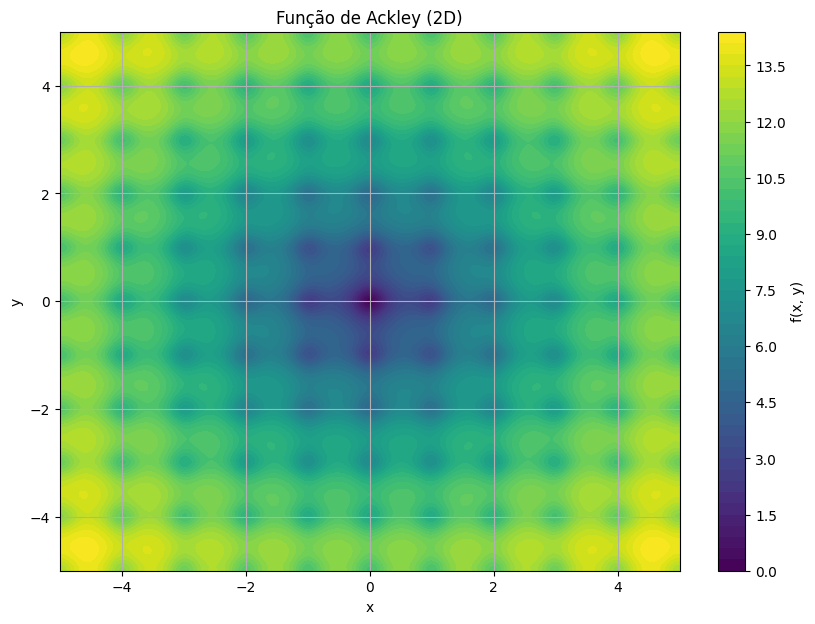

In [ ]:
def ackley_2d(X, Y):
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = ackley([X[i, j], Y[i, j]])
    return Z

x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = ackley_2d(X, Y)

plt.figure(figsize=(10, 7))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='f(x, y)')
plt.title("Função de Ackley (2D)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

Outra forma de visualizar é:

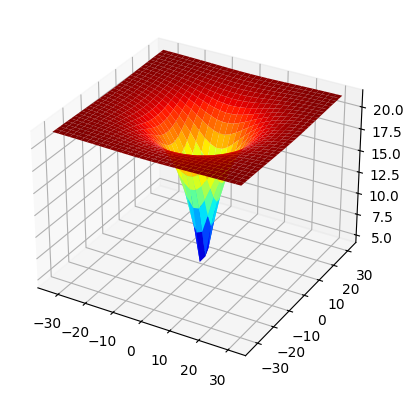

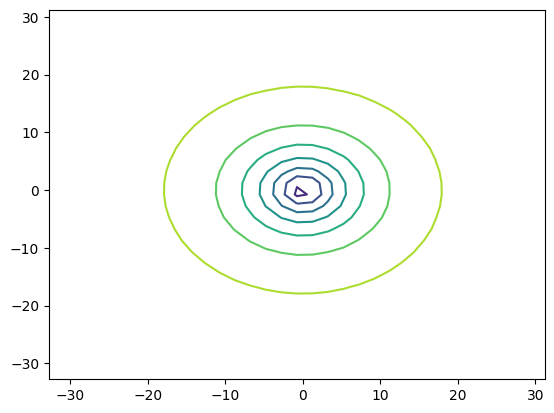

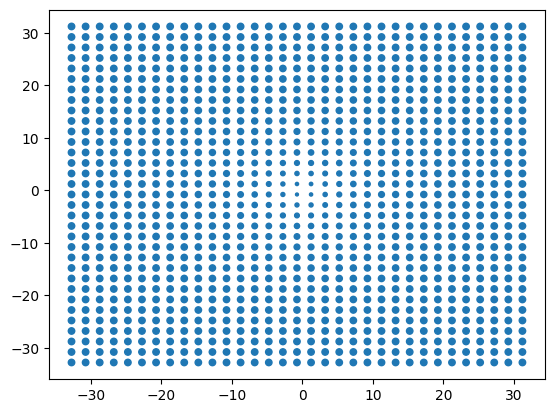

In [ ]:
r_min, r_max = -32.768, 32.768
xaxis = np.arange(r_min, r_max, 2.0)
yaxis = np.arange(r_min, r_max, 2.0)
x, y = np.meshgrid(xaxis, yaxis)
results = ackley_2d(x, y)
fig = plt.figure()
axis = fig.add_subplot(projection = '3d')
axis.plot_surface(x, y, results, cmap='jet', shade= "false")
plt.show()
plt.contour(x,y,results)
plt.show()
plt.scatter(x, y, results)
plt.show()

Nota-se nesses gráficos que a função possui diversos mínimos locais. O código terá que se atentar a isso e ser capaz de não cair neles. Por isso, levanto a hipótese de que **exploração vai ser um investimento mais inteligente do que explotação**.

## Abordagem 1: Algoritmo Genético

### Parâmetros

In [ ]:
D = 30                     # Dimensão do vetor solução
LOWER_BOUND = -5.12        # Limite inferior do domínio da Rastrigin
UPPER_BOUND =  5.12        # Limite superior do domínio da Rastrigin

### Funções

Clamp para garantir que os vetores permaneçam no domínio:

In [ ]:
def clamp_vector(v: np.ndarray, low=LOWER_BOUND, high=UPPER_BOUND) -> np.ndarray:
    return np.clip(v, low, high)

def clamp_inplace(x: np.ndarray, low: float, high: float):
    np.clip(x, low, high, out=x)

Para medir o desvio padrão:

In [ ]:
def population_diversity(pop: np.ndarray) -> float:
  if len(pop) == 0:
    return 0.0
  return float(np.mean(np.std(pop, axis=0)))

Operadores (seleção por torneio, crossover, mutação gaussiana):

In [ ]:
def tournament_select(pop: np.ndarray, fitness: np.ndarray, k: int, rng: np.random.Generator) -> np.ndarray:
    idxs = rng.choice(pop.shape[0], size=k, replace=False)
    best_idx = idxs[np.argmin(fitness[idxs])]
    return pop[best_idx]

def crossover_aritmetico(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    alpha = rng.random()
    return alpha * p1 + (1 - alpha) * p2

def mutacao_gaussiana_inplace(x: np.ndarray, p_mut_gene: float, sigma: float, low: float, high: float, rng: np.random.Generator) -> None:
    d = x.size
    mask = rng.random(d) < p_mut_gene
    # garante ao menos 1 gene mutado
    if not np.any(mask):
        mask[rng.integers(0, d)] = True
    x[mask] += rng.normal(loc=0.0, scale=sigma, size=mask.sum())
    clamp_inplace(x, low, high)

### Executando o Algoritmo

In [ ]:
def run_ga(
  d: int = 30,
  pop_size: int = 500,
  max_evals: int = 100_000,
  p_crossover: float = 0.9,
  p_mut_gene: float | None = None,
  sigma_mut: float = 20.0,
  elitism: int = 2,
  torneio_k: int = 3,
  domain_low: float = LOWER_BOUND,
  domain_high: float = UPPER_BOUND,
  seed: int | None = None,
  log_interval: int = 1,
  verbose: bool = False,
) -> Dict[str, Any]:

  trajectory = []

  if p_mut_gene is None:
    p_mut_gene = 1.0 / d

  rng = np.random.default_rng(seed)

  #inicialização da pop
  pop = rng.uniform(low=domain_low, high=domain_high, size=(pop_size, d))
  #avaliacao do fitness da pop
  fitness = np.array([ackley(ind) for ind in pop])
  evals = pop_size

  #melhor global inicial
  best_idx = int(np.argmin(fitness))
  best_f = float(fitness[best_idx])
  best_x = pop[best_idx].copy()

  # Histórico para análise posterior
  history: List[Dict[str, Any]] = []
  generation = 0
  start_time = time.time()

  #loop evolutivo
  while evals < max_evals:
    elite_indices = np.argsort(fitness)[:elitism]
    elite = pop[elite_indices].copy()
    elite_fitness = fitness[elite_indices].copy()

    # atualizando sigma_mut dinamicamente
    sigma_start = 5.0
    sigma_end = 0.1
    sigma_mut = sigma_start - (sigma_start - sigma_end) * (evals / max_evals)

    div = population_diversity(pop)
    if div < 0.1:
      sigma_mut *= 1.5


    #geração de filhos
    offspring_list = []
    while len(offspring_list) < pop_size - elitism:
      p1 = tournament_select(pop, fitness, torneio_k, rng)
      p2 = tournament_select(pop, fitness, torneio_k, rng)

      child = p1.copy()
      if rng.random() < p_crossover:
        child = crossover_aritmetico(p1, p2, rng)

      mutacao_gaussiana_inplace(child, p_mut_gene, sigma_mut, domain_low, domain_high, rng)
      offspring_list.append(child)

    offspring = np.vstack(offspring_list)
    offspring_fitness = np.array([ackley(ind) for ind in offspring])
    evals += offspring_fitness.size

    #atualização da pop
    pop = np.vstack([elite, offspring])
    fitness = np.concatenate([elite_fitness, offspring_fitness])

    #atualização do melhor global
    current_best_idx = int(np.argmin(fitness))
    current_best_f = float(fitness[current_best_idx])
    current_best_x = pop[current_best_idx].copy()
    if current_best_f < best_f:
      best_f = current_best_f
      best_x = current_best_x.copy()

    #registrando na trajetória
    print("current best: " + str(current_best_f))
    trajectory.append(current_best_x.copy())

    #logging
    if generation % log_interval == 0:
      history.append({
          'generation': generation,
          'evals': evals,
          'best_f': best_f,
          'mean_f': float(np.mean(fitness)),
          'std_f': float(np.std(fitness)),
          'diversity': population_diversity(pop),
      })

      if verbose and generation % (log_interval * 50) == 0:
        print(f"Gen {generation:4d} | evals={evals:6d} | best_f={best_f:.6f} | mean_f={history[-1]['mean_f']:.3f} | div={history[-1]['diversity']:.2f}")

    generation += 1
    if best_f <= 1e-8:
      break

  elapsed = time.time() - start_time
  return {
    'best_f': best_f,
    'best_x': best_x,
    'history': history,
    'final_pop': pop,
    'final_fitness': fitness,
    'evals': evals,
    'elapsed': elapsed,
    'generation': generation,
    'params': {
        'd' : d,
        'pop_size' : pop_size,
        'max_evals' : max_evals,
        'p_crossover' : p_crossover,
        'p_mut_gene' : p_mut_gene,
        'sigma_mut' : sigma_mut,
        'elitism' : elitism,
        'torneio_k' : torneio_k,
    },
    'trajectory': trajectory
  }

A saída de streaming foi truncada nas últimas 5000 linhas.
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 4.094048900688588
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best: 3.619443633644878
current best:

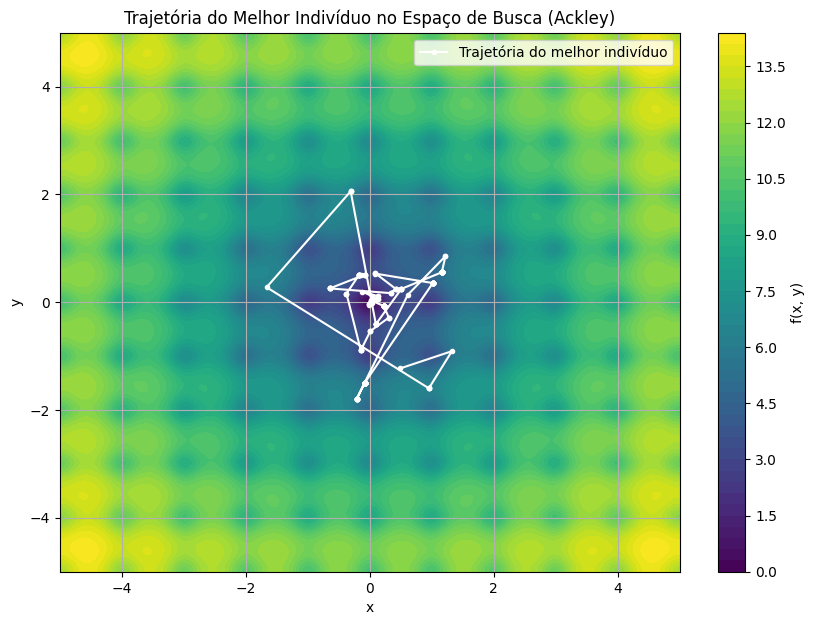

In [ ]:
def main():
    # =========================
    # CONFIGURAÇÕES EXPERIMENTO
    # =========================
    d = 30
    pop_size = 500
    max_evals = 100_000          # orçamento total de avaliações de função
    p_crossover = 0.9
    p_mut_gene = 0.15           # prob. de mutação por gene
    sigma_mut = 20.0               # desvio padrão da mutação gaussiana
    elitism = 2                  # número de indivíduos preservados
    n_runs = 30                  # número de execuções independentes
    base_seed = 123             # seed base para reprodutibilidade

    print("Config GA:")
    print(f"d={d}, pop_size={pop_size}, max_evals={max_evals}, p_crossover={p_crossover}, "
          f"p_mut_gene={p_mut_gene:.4f}, sigma_mut={sigma_mut}, elitism={elitism}, runs={n_runs}")

    all_results = []
    best_values = []
    start_all = time.time()

    for run in range(n_runs):
        seed = base_seed + run
        result = run_ga(
            d=d,
            pop_size=pop_size,
            max_evals=max_evals,
            p_crossover=p_crossover,
            p_mut_gene=p_mut_gene,
            sigma_mut=sigma_mut,
            elitism=elitism,
            seed=seed,
            log_interval=1
        )
        all_results.append(result)
        best_values.append(result['best_f'])
        trajectory = np.array([np.ravel(np.asarray(p)) for p in result['trajectory']])

        x = np.linspace(-5, 5, 400)
        y = np.linspace(-5, 5, 400)
        X, Y = np.meshgrid(x, y)

        points = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape (160000, 2)

        print(f"Run {run+1:02d}/{n_runs} | best_f = {result['best_f']:.6f} | gens = {result['generation']}")

    total_time = time.time() - start_all
    print(f"\\nTempo total (s): {total_time:.2f}")

    # =========================
    # ESTATÍSTICAS FINAIS
    # =========================
    best_values = np.array(best_values)
    print("Resumo dos melhores valores (f(x) – menor é melhor):")
    print(f"Média  : {best_values.mean():.6f}")
    print(f"Mediana: {np.median(best_values):.6f}")
    print(f"Std    : {best_values.std(ddof=1):.6f}")
    print(f"Melhor : {best_values.min():.6f}")
    print(f"Pior   : {best_values.max():.6f}")

    best_run_idx = int(np.argmin(best_values))
    best_result = all_results[best_run_idx]
    best_trajectory = best_result['trajectory']

    x = np.linspace(-5, 5, 400)
    y = np.linspace(-5, 5, 400)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z = np.array([ackley(p) for p in points]).reshape(X.shape)

    traj = np.array([np.asarray(p) for p in best_trajectory])

    plt.figure(figsize=(10, 7))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='f(x, y)')
    plt.plot(traj[:, 0], traj[:, 1], 'w.-', label='Trajetória do melhor indivíduo')
    plt.title("Trajetória do Melhor Indivíduo no Espaço de Busca (Ackley)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()


## Abordagem 2: Estratégia Evolutiva
### Parâmetros

In [ ]:
#inicialização pais
# mu: num pais
# d : dim
# domain_low/high : limites
# init_sigma_frac : fração do range para iniciar sigma

#retorna: posições e desvios padrão inciais

def initialize_es(mu: int, d: int,
                  domain_low: float, domain_high: float,
                  init_sigma_frac: float,
                  rng):
    X = rng.uniform(domain_low, domain_high, size=(mu, d))
    range_width = domain_high - domain_low
    SIGMA = np.full((mu, d), init_sigma_frac * range_width, dtype=float)
    return X, SIGMA

### Funções

In [ ]:
def recombine_discrete(parents_idx, X, SIGMA, rng):
    parents_x = X[parents_idx]
    parents_s = SIGMA[parents_idx]
    num_parents, d = parents_x.shape
    child_x = np.empty(d, dtype=float)
    child_sigma = np.empty(d, dtype=float)
    for j in range(d):
        p = rng.integers(0, num_parents)
        child_x[j] = parents_x[p, j]
        child_sigma[j] = parents_s[p, j]
    return child_x, child_sigma

In [ ]:
def mutate_strategy_and_object(child_x, child_sigma, tau_prime, tau, rng, domain_low, domain_high):
    d = child_x.shape[0]
    global_noise = rng.normal()
    gene_noise = rng.normal(size=d)
    child_sigma = child_sigma * np.exp(tau_prime * global_noise + tau * gene_noise)
    child_sigma = np.clip(child_sigma, 1e-8, (domain_high - domain_low) * 0.2) # Limitar sigma
    child_x += child_sigma * gene_noise # Mutação do objeto usa gene_noise diferente da estratégia
    clamp_inplace(child_x, domain_low, domain_high)
    return child_x, child_sigma

### Executando o algoritmo

In [ ]:
def run_es(
    d=30,
    mu=50,
    lamb=200,
    max_evals=100_000,
    init_sigma_frac=0.1,
    seed=0,
    verbose=False,
    log_interval=10
):
    np.random.seed(seed)
    evals = 0
    bounds = (-32.768, 32.768)

    # Inicializar população
    pop = np.random.uniform(bounds[0], bounds[1], size=(mu, d))
    sigmas = np.ones((mu, d)) * ((bounds[1] - bounds[0]) * init_sigma_frac)
    fitness = np.array([ackley(ind) for ind in pop])
    evals += mu

    trajectory = []
    best_idx = np.argmin(fitness)
    best_ind = pop[best_idx].copy()
    best_f = fitness[best_idx]
    trajectory.append(best_ind.copy())

    generation = 0
    tau = 1 / np.sqrt(2 * np.sqrt(d))
    tau_prime = 1 / np.sqrt(2 * d)

    while evals < max_evals:
        # Recombinação intermediária
        idxs = np.random.randint(0, mu, size=(lamb, 2))
        x_off = (pop[idxs[:, 0]] + pop[idxs[:, 1]]) / 2.0
        sigma_off = (sigmas[idxs[:, 0]] + sigmas[idxs[:, 1]]) / 2.0

        # Mutação com adaptação log-normal
        noise = np.random.randn(lamb, d)
        sigma_off *= np.exp(tau_prime * np.random.randn(lamb, 1) + tau * noise)
        x_off += sigma_off * np.random.randn(lamb, d)

        # Avaliação
        x_off = np.clip(x_off, bounds[0], bounds[1])
        fit_off = np.array([ackley(ind) for ind in x_off])
        evals += lamb

        # Seleção (μ+λ)
        combined_pop = np.vstack([pop, x_off])
        combined_sigmas = np.vstack([sigmas, sigma_off])
        combined_fitness = np.hstack([fitness, fit_off])

        best_idxs = np.argsort(combined_fitness)[:mu]
        pop = combined_pop[best_idxs]
        sigmas = combined_sigmas[best_idxs]
        fitness = combined_fitness[best_idxs]

        best_idx = np.argmin(fitness)
        best_ind = pop[best_idx].copy()
        best_f = fitness[best_idx]
        trajectory.append(best_ind.copy())

        generation += 1
        if best_f <= 1e-8:
            break
        if verbose and generation % log_interval == 0:
            print(f"Gen {generation:4d} | best_f = {best_f:.6f}")

    return {
        'best_f': best_f,
        'best_ind': best_ind,
        'generation': generation,
        'trajectory': trajectory
    }


Run 01/30 | best_f = 0.000000 | gens = 298
Run 02/30 | best_f = 0.000000 | gens = 282
Run 03/30 | best_f = 0.000000 | gens = 300
Run 04/30 | best_f = 0.000000 | gens = 293
Run 05/30 | best_f = 0.000000 | gens = 273
Run 06/30 | best_f = 0.000000 | gens = 308
Run 07/30 | best_f = 0.000000 | gens = 273
Run 08/30 | best_f = 0.000000 | gens = 292
Run 09/30 | best_f = 0.000000 | gens = 289
Run 10/30 | best_f = 0.000000 | gens = 291
Run 11/30 | best_f = 0.000000 | gens = 291
Run 12/30 | best_f = 0.000000 | gens = 294
Run 13/30 | best_f = 0.000000 | gens = 283
Run 14/30 | best_f = 0.000000 | gens = 278
Run 15/30 | best_f = 0.000000 | gens = 283
Run 16/30 | best_f = 0.000000 | gens = 274
Run 17/30 | best_f = 0.000000 | gens = 303
Run 18/30 | best_f = 0.000000 | gens = 283
Run 19/30 | best_f = 0.000000 | gens = 319
Run 20/30 | best_f = 0.000000 | gens = 303
Run 21/30 | best_f = 0.000000 | gens = 303
Run 22/30 | best_f = 0.000000 | gens = 273
Run 23/30 | best_f = 0.931305 | gens = 500
Run 24/30 |

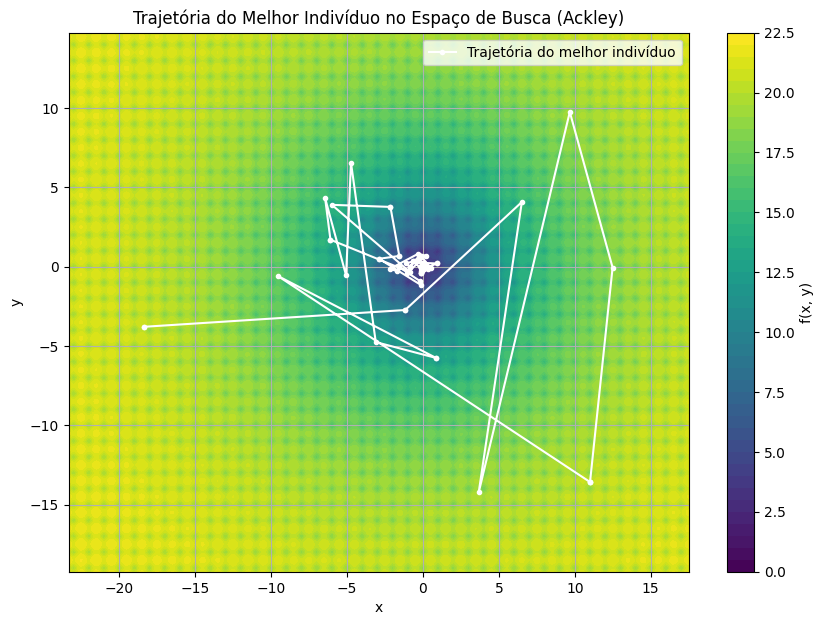

In [ ]:
# Função principal
def main_es():
    d = 30
    mu = 30
    lambd = 200
    max_evals = 100_000
    init_sigma_frac = 0.2
    n_runs = 30
    base_seed = 123

    all_results = []
    best_values = []

    start_all = time.time()

    for run in range(n_runs):
        seed = base_seed + run
        result = run_es(d, mu, lambd, max_evals, init_sigma_frac, seed=seed)
        all_results.append(result)
        best_values.append(result['best_f'])

        print(f"Run {run+1:02d}/{n_runs} | best_f = {result['best_f']:.6f} | gens = {result['generation']}")

    total_time = time.time() - start_all
    print(f"\nTempo total (s): {total_time:.2f}")

    best_values = np.array(best_values)
    print("Resumo dos melhores valores (f(x) – menor é melhor):")
    print(f"Média  : {best_values.mean():.6f}")
    print(f"Mediana: {np.median(best_values):.6f}")
    print(f"Std    : {best_values.std(ddof=1):.6f}")
    print(f"Melhor : {best_values.min():.6f}")
    print(f"Pior   : {best_values.max():.6f}")

    best_run_idx = int(np.argmin(best_values))
    best_result = all_results[best_run_idx]
    best_trajectory = best_result['trajectory']

    traj = np.array([np.asarray(p[:2]) for p in best_trajectory])
    margin = 5
    x_min, x_max = traj[:, 0].min() - margin, traj[:, 0].max() + margin
    y_min, y_max = traj[:, 1].min() - margin, traj[:, 1].max() + margin
    x = np.linspace(x_min, x_max, 400)
    y = np.linspace(y_min, y_max, 400)
    X, Y = np.meshgrid(x, y)

    points = np.stack([X.ravel(), Y.ravel()], axis=1)
    Z = np.array([ackley(p) for p in points]).reshape(X.shape)

    plt.figure(figsize=(10, 7))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='f(x, y)')
    plt.plot(traj[:, 0], traj[:, 1], 'w.-', label='Trajetória do melhor indivíduo')
    plt.title("Trajetória do Melhor Indivíduo no Espaço de Busca (Ackley)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main_es()


## Análise & Comparação

In [ ]:
print("--- Executando Algoritmo Genético para Ackley ---")
ga_results = run_ga(seed=123, max_evals=100000)
print("-" * 50)

print("\n--- Executando Estratégia Evolutiva para Ackley ---")
es_results = run_es(seed=123, max_evals=100000)
print("-" * 50)

print("\nResultados Finais:")
print(f"  GA Melhor Fitness: {ga_results['best_f']:.8f}")
print(f"  ES Melhor Fitness: {es_results['best_f']:.8f}")

--- Executando Algoritmo Genético para Ackley ---
current best: 6.974029032593634
current best: 5.701450914683079
current best: 4.997607591972713
current best: 4.283190903701691
current best: 3.871018672712179
current best: 3.4535685466909922
current best: 3.215407762861894
current best: 2.982217622704493
current best: 2.9350977517512367
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5468071770474165
current best: 2.5419408095593288
current best: 2.3261543879559956
current best: 2.3261543879559956
current best: 2.1144471988153843
current best: 2.1144471988153843
current best: 2.1144471988153843
current best: 2.1144471988153843
current best: 2.0831145190635643
current best: 2.0831145190635643
current best: 1.7800693403225378
current best: 1.7800693403225378
current best: 1.7800693403225378
